In [1]:
%%html
<style>
/* Do not render this cell */
@media print {
  .jp-Cell.jp-Notebook-cell:first-child {
    display: none;
  }
}

:root {
  --jp-content-link-color: dodgerblue;
}
@page {
  size: A3 portrait;
  margin: 0;
}
a code {
  color: var(--jp-content-link-color) !important;
}
body {
  font-family: sans-serif;
  font-size: 14px;
}
h1, h2, h3, h4, h5, h6, strong {
  font-weight: bolder;
}
hr {
  visibility: hidden;
  page-break-before: always;
}
pre {
  white-space: pre-wrap;
}
table, tr, td, th, tbody, thead, tfoot {
  page-break-inside: avoid !important;
}
.jp-RenderedHTMLCommon table {
  margin-left: 2em;
}
</style>

# Video Compression Assignment 2

## Task 1

> Motion Estimation

Please apply the full-search block-matching algorithm to the luma component of `foreman_qcif_1_rgb.bmp` with the reference frame `foreman_qcif_0_rgb.bmp`.

The collocated position in the reference frame of the top-left pixel of each MB is the center of the search window.

The search range is set to [-16, 15]. The similarity  metric is SAD. Please show MVs for all the MBs in the video frame.

## Solution of Task 1

In [2]:
%pip install \
    --disable-pip-version-check \
    --quiet \
    numpy \
    Pillow

Note: you may need to restart the kernel to use updated packages.


The marcoblock size is 16x16, and the search window size is 32x32:

In [3]:
block_size = (16, 16)
search_size = (32, 32)

The top-left pixel of a macroblock is the block index as well as the center of the search window:

```plaintext
o: block index
+: other pixel

o + + +
+ + + +
+ + + +
+ + + +
```

For a search window locates at the `center`, the range of block index to search is `[center - window_size // 2, center]`:

```plaintext
o: search block index
x: center block index (also search block index)
+: other pixel

o o o o|o + + +
o o o o|o + + +
o o o o|o + + +
o o o o|o + + +
-------+-------
o o o o|x + + +
+ + + +|+ + + +
+ + + +|+ + + +
+ + + +|+ + + +
```

In [4]:
from IPython.display import display

search_block_index_range = (
    (-search_size[0] // 2, 0),
    (-search_size[1] // 2, 0),
)
display(search_block_index_range)

((-16, 0), (-16, 0))

Wrap these concepts into functions:

In [5]:
from typing import Iterable
from PIL.Image import Image


def get_grid_size(frame: Image) -> tuple[int, int]:
    return (frame.width, frame.height)


def get_block_indexs(
    grid_size: tuple[int, int],
    block_size: tuple[int, int],
) -> tuple[Iterable[int], Iterable[int]]:
    assert grid_size[0] >= block_size[0], (grid_size[0], block_size[0])
    assert grid_size[1] >= block_size[1], (grid_size[1], block_size[1])
    return (
        range(0, grid_size[0] - block_size[0] + 1, block_size[0]),
        range(0, grid_size[1] - block_size[1] + 1, block_size[1]),
    )


def get_block_index_bound(
    frame: Image,
) -> tuple[tuple[int, int], tuple[int, int]]:
    return ((0, max(frame.width - 1, 0)), (0, max(frame.height - 1, 0)))


def get_search_block_indexs(
    center_block_index: tuple[int, int],
    search_block_index_range: tuple[tuple[int, int], tuple[int, int]],
    block_index_bound: tuple[tuple[int, int], tuple[int, int]],
) -> tuple[Iterable[int], Iterable[int]]:

    def minmax(value: int, min_value: int, max_value: int) -> int:
        return max(min(value, max_value), min_value)

    return (
        range(
            minmax(
                center_block_index[0] + search_block_index_range[0][0],
                block_index_bound[0][0],
                block_index_bound[0][1],
            ),
            minmax(
                center_block_index[0] + search_block_index_range[0][1],
                block_index_bound[0][0],
                block_index_bound[0][1],
            )
            + 1,
        ),
        range(
            minmax(
                center_block_index[1] + search_block_index_range[1][0],
                block_index_bound[1][0],
                block_index_bound[1][1],
            ),
            minmax(
                center_block_index[1] + search_block_index_range[1][1],
                block_index_bound[1][0],
                block_index_bound[1][1],
            )
            + 1,
        ),
    )

The similarity metric is SAD, which is the sum of absolute differences between two blocks:

In [6]:
from numpy.typing import NDArray


def get_score_sad(
    block_pair: tuple[NDArray, NDArray],
) -> int:
    from numpy import abs

    return abs(block_pair[0] - block_pair[1]).sum(dtype=int)

Load the images and extract their luma component:

In [7]:
import PIL.Image as Image
from numpy import asarray

reference_frame = Image.open("../resources/foreman_qcif_0_rgb.bmp").convert("L")
current_frame = Image.open("../resources/foreman_qcif_1_rgb.bmp").convert("L")

reference_buffer = asarray(reference_frame)
current_buffer = asarray(current_frame)

In [8]:
grid_size = get_grid_size(current_frame)
block_index_bound = get_block_index_bound(current_frame)

display(
    dict(
        grid_size=grid_size,
        block_index_bound=block_index_bound,
    )
)

{'grid_size': (176, 144), 'block_index_bound': ((0, 175), (0, 143))}

Perform full-search block-matching algorithm and calculate the motion vectors (`reference - current`):

In [9]:
from sys import maxsize

motion_vectors_by_full_search: list[list[tuple[int, int]]] = []

center_block_x_indexs, center_block_y_indexs = get_block_indexs(
    grid_size, block_size
)
for center_block_y_index in center_block_y_indexs:

    motion_vectors_x: list[tuple[int, int]] = []
    for center_block_x_index in center_block_x_indexs:
        center_block = current_buffer[
            center_block_y_index : center_block_y_index + block_size[1],
            center_block_x_index : center_block_x_index + block_size[0],
        ]

        search_block_x_indexs, search_block_y_indexs = get_search_block_indexs(
            (center_block_x_index, center_block_y_index),
            search_block_index_range,
            block_index_bound,
        )
        best_score = maxsize
        motion_vector: tuple[int, int] = None
        for search_block_y_index in search_block_y_indexs:
            for search_block_x_index in search_block_x_indexs:
                search_block = reference_buffer[
                    search_block_y_index : search_block_y_index + block_size[1],
                    search_block_x_index : search_block_x_index + block_size[0],
                ]
                score = get_score_sad((search_block, center_block))

                if best_score > score:
                    best_score = score
                    motion_vector = (
                        search_block_x_index - center_block_x_index,
                        search_block_y_index - center_block_y_index,
                    )

        motion_vectors_x.append(motion_vector)

    motion_vectors_by_full_search.append(motion_vectors_x)

Render the output:

In [10]:
from IPython.display import display, Markdown

table_markdown_str = "| y \\ x |"
for center_block_x_index in center_block_x_indexs:
    table_markdown_str += f" {center_block_x_index} |"
table_markdown_str += "\n"

table_markdown_str += (
    "|-------|" + "----------|" * len(center_block_x_indexs) + "\n"
)

for center_block_y_index, motion_vectors_x in zip(
    center_block_y_indexs, motion_vectors_by_full_search
):
    table_markdown_str += f"| {center_block_y_index} |"
    for motion_vector in motion_vectors_x:
        table_markdown_str += f" {motion_vector} |"
    table_markdown_str += "\n"

display(
    Markdown(
        f"Display the motion vectors `(mx, my)` in the table below:\n{table_markdown_str}"
    )
)

Display the motion vectors `(mx, my)` in the table below:
| y \ x | 0 | 16 | 32 | 48 | 64 | 80 | 96 | 112 | 128 | 144 | 160 |
|-------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|
| 0 | (0, 0) | (0, 0) | (0, 0) | (0, 0) | (0, 0) | (0, 0) | (-12, 0) | (-6, 0) | (-4, 0) | (-3, 0) | (-16, 0) |
| 16 | (0, -16) | (0, 0) | (0, 0) | (0, 0) | (0, -2) | (0, -2) | (-6, 0) | (-14, -7) | (-15, -14) | (-16, -13) | (0, 0) |
| 32 | (0, 0) | (0, 0) | (0, 0) | (0, 0) | (0, -16) | (0, 0) | (-5, 0) | (-11, -3) | (-14, -4) | (0, -16) | (-10, -7) |
| 48 | (0, 0) | (0, 0) | (-13, -1) | (-3, -4) | (-13, 0) | (-2, -8) | (-6, 0) | (0, 0) | (0, 0) | (-5, -9) | (-1, -16) |
| 64 | (0, -7) | (-6, -2) | (0, 0) | (-4, -11) | (-16, -9) | (-16, -12) | (-7, 0) | (0, 0) | (0, 0) | (0, 0) | (0, 0) |
| 80 | (0, 0) | (-7, 0) | (-6, -3) | (0, -6) | (-2, -2) | (-16, 0) | (-6, 0) | (-2, 0) | (-3, -6) | (0, -6) | (-6, -7) |
| 96 | (0, -2) | (-14, -5) | (-6, -2) | (-7, 0) | (-3, -15) | (-15, -10) | (-16, -12) | (-3, 0) | (-14, -10) | (-12, -14) | (-1, -7) |
| 112 | (0, -15) | (-14, -16) | (-13, 0) | (-5, 0) | (0, -16) | (-1, 0) | (-4, 0) | (-3, -5) | (-16, -16) | (-16, -5) | (-6, -13) |
| 128 | (0, -5) | (-13, -8) | (-15, 0) | (-16, 0) | (-14, -13) | (-15, -1) | (0, 0) | (-15, -6) | (-16, -14) | (0, 0) | (0, 0) |


----

## Task 2

> Motion Estimation

Following the previous question, please implement the diamond-search algorithm. 

## Solution of Task 2

The diamond search pattern of radius 2:

```plaintext
o: search block index
x: center block index (also search block index)
+: other pixel

+ + + + + + +
+ + + o + + +
+ + o + o + +
+ o + x + o +
+ + o + o + +
+ + + o + + +
+ + + + + + +
```

Write this concept into a function:

In [11]:
def get_diamond_search_block_indexs(
    center_block_index: tuple[int, int],
    search_block_radius: int,
    block_index_bound: tuple[tuple[int, int], tuple[int, int]],
    block_size: tuple[int, int],
) -> Iterable[tuple[int, int]]:
    def get_diamond_search_block_index_relative(search_block_radius: int):
        search_block_radius = max(search_block_radius, 0)
        if search_block_radius > 0:
            yield (-search_block_radius, 0)
        for rx in range(-search_block_radius + 1, 0):
            ry = rx + search_block_radius
            yield (rx, -ry)
            yield (rx, +ry)
        if search_block_radius > 0:
            yield (0, -search_block_radius)
        yield (0, 0)
        if search_block_radius > 0:
            yield (0, +search_block_radius)
        for rx in range(1, search_block_radius):
            ry = rx - search_block_radius
            yield (rx, +ry)
            yield (rx, -ry)
        if search_block_radius > 0:
            yield (+search_block_radius, 0)

    for search_block_index_relative in get_diamond_search_block_index_relative(
        search_block_radius
    ):
        search_block_index = (
            center_block_index[0] + search_block_index_relative[0],
            center_block_index[1] + search_block_index_relative[1],
        )
        if (
            block_index_bound[0][0]
            <= search_block_index[0]
            <= block_index_bound[0][1]
            and block_index_bound[1][0]
            <= search_block_index[1]
            <= block_index_bound[1][1]
            and block_index_bound[0][0]
            <= search_block_index[0] + block_size[0] - 1
            <= block_index_bound[0][1]
            and block_index_bound[1][0]
            <= search_block_index[1] + block_size[1] - 1
            <= block_index_bound[1][1]
        ):
            yield search_block_index

Take this as an example:

```plaintext
o: search block index
x: center block index (also search block index)
+: other pixel

+ o + o + +
o + + + o +
+ + x + + o
o + + + o +
+ o + o + +
+ + o + + +
```

In [12]:
display(
    list(
        get_diamond_search_block_indexs(
            center_block_index=(2, 2),
            search_block_radius=3,
            block_index_bound=block_index_bound,
            block_size=block_size,
        )
    )
)

[(0, 1),
 (0, 3),
 (1, 0),
 (1, 4),
 (2, 2),
 (2, 5),
 (3, 0),
 (3, 4),
 (4, 1),
 (4, 3),
 (5, 2)]

Perform diamond-search block-matching algorithm and calculate the motion vectors (`reference - current`):

In [13]:
search_block_radius_init = block_size[0] // 2
display(search_block_radius_init)

8

In [14]:
from sys import maxsize

motion_vectors_by_diamond_search: list[list[tuple[int, int]]] = []

center_block_x_indexs, center_block_y_indexs = get_block_indexs(
    grid_size, block_size
)
for center_block_y_index in center_block_y_indexs:

    motion_vectors_x: list[tuple[int, int]] = []
    for center_block_x_index in center_block_x_indexs:
        current_center_block_x_index = reference_center_block_x_index = (
            center_block_x_index
        )
        current_center_block_y_index = reference_center_block_y_index = (
            center_block_y_index
        )
        center_block = current_buffer[
            current_center_block_y_index : current_center_block_y_index
            + block_size[1],
            current_center_block_x_index : current_center_block_x_index
            + block_size[0],
        ]

        search_block_radius = search_block_radius_init
        while search_block_radius > 0:
            search_block_indexs = get_diamond_search_block_indexs(
                (
                    reference_center_block_x_index,
                    reference_center_block_y_index,
                ),
                search_block_radius,
                block_index_bound,
                block_size,
            )
            best_score = maxsize
            best_reference_center_block_x_index: int = None
            best_reference_center_block_y_index: int = None
            for (
                search_block_x_index,
                search_block_y_index,
            ) in search_block_indexs:
                search_block = reference_buffer[
                    search_block_y_index : search_block_y_index + block_size[1],
                    search_block_x_index : search_block_x_index + block_size[0],
                ]
                score = get_score_sad((search_block, center_block))
                if best_score > score:
                    best_score = score
                    best_reference_center_block_x_index = search_block_x_index
                    best_reference_center_block_y_index = search_block_y_index

            if (
                reference_center_block_x_index
                == best_reference_center_block_x_index
                and reference_center_block_y_index
                == best_reference_center_block_y_index
            ):
                search_block_radius -= 1

            reference_center_block_x_index = best_reference_center_block_x_index
            reference_center_block_y_index = best_reference_center_block_y_index

        motion_vector = (
            reference_center_block_x_index - current_center_block_x_index,
            reference_center_block_y_index - current_center_block_y_index,
        )
        motion_vectors_x.append(motion_vector)

    motion_vectors_by_diamond_search.append(motion_vectors_x)

Render the output:

In [15]:
from IPython.display import display, Markdown

table_markdown_str = "| y \\ x |"
for center_block_x_index in center_block_x_indexs:
    table_markdown_str += f" {center_block_x_index} |"
table_markdown_str += "\n"

table_markdown_str += (
    "|-------|" + "----------|" * len(center_block_x_indexs) + "\n"
)

for center_block_y_index, motion_vectors_x in zip(
    center_block_y_indexs, motion_vectors_by_diamond_search
):
    table_markdown_str += f"| {center_block_y_index} |"
    for motion_vector in motion_vectors_x:
        table_markdown_str += f" {motion_vector} |"
    table_markdown_str += "\n"

display(
    Markdown(
        f"Display the motion vectors `(mx, my)` in the table below:\n{table_markdown_str}"
    )
)

Display the motion vectors `(mx, my)` in the table below:
| y \ x | 0 | 16 | 32 | 48 | 64 | 80 | 96 | 112 | 128 | 144 | 160 |
|-------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|
| 0 | (0, 0) | (0, 0) | (0, 0) | (0, 0) | (8, 14) | (6, 21) | (-4, 19) | (-6, 0) | (-4, 0) | (14, 16) | (-4, 23) |
| 16 | (0, 0) | (0, 0) | (0, 0) | (9, 12) | (19, -3) | (8, 3) | (-5, 4) | (-6, 5) | (-15, -14) | (0, 3) | (0, 0) |
| 32 | (0, 0) | (0, 0) | (0, 0) | (9, -14) | (24, -4) | (0, 0) | (-5, 0) | (-11, -3) | (11, 10) | (-15, 11) | (-10, -7) |
| 48 | (17, -6) | (0, 0) | (-2, -5) | (7, -8) | (-15, 3) | (-4, 1) | (-5, 1) | (2, 1) | (3, -6) | (0, 0) | (0, 0) |
| 64 | (17, -13) | (-6, -2) | (0, 0) | (7, -16) | (-1, 12) | (2, 3) | (-4, 9) | (2, -2) | (0, 0) | (0, 0) | (0, 0) |
| 80 | (0, 9) | (0, 16) | (-6, -3) | (9, 8) | (-2, -2) | (-15, 3) | (7, 5) | (-2, 1) | (17, 4) | (1, -6) | (0, 0) |
| 96 | (0, -2) | (-14, -5) | (0, 7) | (-1, 4) | (1, 0) | (5, 11) | (-7, 11) | (-9, 10) | (-14, -10) | (3, -4) | (-1, -7) |
| 112 | (0, -23) | (-14, 4) | (-16, 8) | (-1, 4) | (10, -32) | (0, 1) | (-4, 0) | (-3, -5) | (0, 0) | (-19, -5) | (-6, -13) |
| 128 | (0, -5) | (-13, -8) | (-29, -4) | (-16, 0) | (-14, -13) | (19, -1) | (1, -2) | (0, 0) | (15, -4) | (9, 0) | (0, 0) |


----

## Task 3

> Intra-frame Prediction

Please apply intra-prediction to the luma component of `foreman_qcif_0_rgb.bmp`.

You only need to implement the four modes (Mode 0, 1, 2, and 4) for the 16x16 luma MB. You do not make an intra-prediction to the top-left MB since there is no predictor for it.

The similarity metric is also SAD. If any pixels are unavailable for a mode, you will not choose it. Please plot the mode for each MB using the example figure below.

```plaintext
| x   | 1   | ... | 2   |
| 4   | 1   | ... | 2   |
| ... | ... | ... | ... |
| 0   | 0   | ... | 4   |
| 0   | 0   | ... | 4   |
```


## Solution of Task 3

There are four modes for 16x16 macroblocks in intra-frame prediction:

- Mode 0: Vertical
- Mode 1: Horizontal
- Mode 2: DC
- Mode 4: Diagonal down-right


To simplify illustrations, the block size downgrades to 4x4.

The encoded and prediction partitions are illustrated as follows:

```plaintext
e: encoded pixel (source)
p: predicted pixel (target)

| Mode 0    | Mode 1    | Mode 2    | Mode 4    |
|-----------|-----------|-----------|-----------|
|   e e e e |           |   e e e e | e e e e   |
|   p p p p | e p p p p | e p p p p | e p p p p |
|   p p p p | e p p p p | e p p p p | e p p p p |
|   p p p p | e p p p p | e p p p p | e p p p p |
|   p p p p | e p p p p | e p p p p |   p p p p |
```

The predicted data is calculated as the following illustrations:

```plaintext
Before:

| Mode 0    | Mode 1    | Mode 2    | Mode 4    |
|-----------|-----------|-----------|-----------|
|   a b c d |           |   a b c d | m a b c   |
|   . . . . | i . . . . | i . . . . | i . . . . |
|   . . . . | j . . . . | j . . . . | j . . . . |
|   . . . . | k . . . . | k . . . . | k . . . . |
|   . . . . | l . . . . | l . . . . |   . . . . |


After:

| Mode 0    | Mode 1    | Mode 2    | Mode 4    |
|-----------|-----------|-----------|-----------|
|   a b c d |           |   a b c d | m a b c   |
|   a b c d | i i i i i | i u u u u | i m a b c |
|   a b c d | j j j j j | j u u u u | j i m a b |
|   a b c d | k k k k k | k u u u u | k j i m a |
|   a b c d | l l l l l | l u u u u |   k j i m |

* u = the average of a, b, c, d, i, j, k, l
```

Wrap these concepts into functions:

In [16]:
from numpy.typing import NDArray
from typing import Optional


def has_top_predictor(
    block_index: tuple[int, int],
    block_index_bound: tuple[tuple[int, int], tuple[int, int]],
) -> bool:
    return (
        block_index_bound[1][0] <= block_index[1] - 1 <= block_index_bound[1][1]
    )


def has_left_predictor(
    block_index: tuple[int, int],
    block_index_bound: tuple[tuple[int, int], tuple[int, int]],
) -> bool:
    return (
        block_index_bound[0][0] <= block_index[0] - 1 <= block_index_bound[0][1]
    )


def get_predicted_block_in_vertical_mode(
    frame_buffer: NDArray,
    block_index: tuple[int, int],
    block_size: tuple[int, int],
    block_index_bound: tuple[tuple[int, int], tuple[int, int]],
) -> Optional[NDArray]:
    from numpy import full

    if not has_top_predictor(block_index, block_index_bound):
        return

    top_predictor_buffer = frame_buffer[
        block_index[1] - 1,
        block_index[0] : block_index[0] + block_size[0],
    ]
    predicted_block = full(
        (block_size[1], block_size[0]),
        top_predictor_buffer,
    )

    return predicted_block


def get_predicted_block_in_horizontal_mode(
    frame_buffer: NDArray,
    block_index: tuple[int, int],
    block_size: tuple[int, int],
    block_index_bound: tuple[tuple[int, int], tuple[int, int]],
) -> Optional[NDArray]:
    from numpy import full

    if not has_left_predictor(block_index, block_index_bound):
        return

    left_predictor_buffer = frame_buffer[
        block_index[1] : block_index[1] + block_size[1],
        block_index[0] - 1,
    ]
    predicted_block = full(
        (block_size[1], block_size[0]),
        left_predictor_buffer.reshape(-1, 1),
    )

    return predicted_block


def get_predicted_block_in_dc_mode(
    frame_buffer: NDArray,
    block_index: tuple[int, int],
    block_size: tuple[int, int],
    block_index_bound: tuple[tuple[int, int], tuple[int, int]],
) -> Optional[NDArray]:
    from numpy import full

    if not has_left_predictor(
        block_index,
        block_index_bound,
    ) or not has_top_predictor(
        block_index,
        block_index_bound,
    ):
        return

    top_predictor_buffer = frame_buffer[
        block_index[1] - 1,
        block_index[0] : block_index[0] + block_size[0],
    ]
    left_predictor_buffer = frame_buffer[
        block_index[1] : block_index[1] + block_size[1],
        block_index[0] - 1,
    ]
    average_value = (
        top_predictor_buffer.sum(dtype=int)
        + left_predictor_buffer.sum(dtype=int)
    ) // (top_predictor_buffer.size + left_predictor_buffer.size)
    predicted_block = full((block_size[1], block_size[0]), average_value)

    return predicted_block


def get_predicted_block_in_diagonal_downright_mode(
    frame_buffer: NDArray,
    block_index: tuple[int, int],
    block_size: tuple[int, int],
    block_index_bound: tuple[tuple[int, int], tuple[int, int]],
) -> Optional[NDArray]:
    from numpy import empty

    if not has_left_predictor(
        block_index,
        block_index_bound,
    ) or not has_top_predictor(
        block_index,
        block_index_bound,
    ):
        return

    predicted_block = empty(
        (block_size[1], block_size[0]), dtype=frame_buffer.dtype
    )
    diag_size = min(block_size[0], block_size[1])

    for predict_count, predictor_y_index_relative in zip(
        range(1, diag_size + 1), range(diag_size - 2, -2, -1)
    ):
        predictor_index = (
            block_index[0] - 1,
            block_index[1] + predictor_y_index_relative,
        )
        for predicted_index_relative in range(predict_count):
            predicted_index = (
                predicted_index_relative,
                predicted_index_relative + predictor_y_index_relative + 1,
            )
            predicted_block[predicted_index[1], predicted_index[0]] = (
                frame_buffer[
                    predictor_index[1],
                    predictor_index[0],
                ]
            )

    for predict_count, predictor_x_index_relative in zip(
        range(diag_size - 1, 0, -1), range(0, diag_size - 1)
    ):
        predictor_index = (
            block_index[0] + predictor_x_index_relative,
            block_index[1] - 1,
        )
        for predicted_index_relative in range(predict_count):
            predicted_index = (
                predicted_index_relative + predictor_x_index_relative + 1,
                predicted_index_relative,
            )
            predicted_block[predicted_index[1], predicted_index[0]] = (
                frame_buffer[
                    predictor_index[1],
                    predictor_index[0],
                ]
            )

    return predicted_block

Load the image and extract the luma component:

In [17]:
import PIL.Image as Image
from numpy import asarray

source_frame = Image.open("../resources/foreman_qcif_0_rgb.bmp").convert("L")
source_buffer = asarray(source_frame)

In [18]:
grid_size = get_grid_size(source_frame)
block_index_bound = get_block_index_bound(source_frame)

display(
    dict(
        grid_size=grid_size,
        block_index_bound=block_index_bound,
    )
)

{'grid_size': (176, 144), 'block_index_bound': ((0, 175), (0, 143))}

Perform intra-frame prediction and calculate the predicted mode and frame:

In [19]:
from numpy import zeros_like
from sys import maxsize

modes: list[list[str]] = []
predicted_buffer = zeros_like(source_buffer)

prediction_functions = {
    0: get_predicted_block_in_vertical_mode,
    1: get_predicted_block_in_horizontal_mode,
    2: get_predicted_block_in_dc_mode,
    4: get_predicted_block_in_diagonal_downright_mode,
}

block_x_indexs, block_y_indexs = get_block_indexs(grid_size, block_size)
for block_y_index in block_y_indexs:

    modes_x: list[str] = []
    for block_x_index in block_x_indexs:
        source_block = source_buffer[
            block_y_index : block_y_index + block_size[1],
            block_x_index : block_x_index + block_size[0],
        ]

        best_score = maxsize
        best_mode = None
        best_predicted_block = None
        for mode, prediction_function in prediction_functions.items():
            predicted_block = prediction_function(
                source_buffer,
                (block_x_index, block_y_index),
                block_size,
                block_index_bound,
            )
            if predicted_block is not None:
                score = get_score_sad((predicted_block, source_block))
                if best_score > score:
                    best_score = score
                    best_mode = mode
                    best_predicted_block = predicted_block

        modes_x.append(best_mode)

        if best_predicted_block is not None:
            predicted_buffer[
                block_y_index : block_y_index + block_size[1],
                block_x_index : block_x_index + block_size[0],
            ] = best_predicted_block

    modes.append(modes_x)

Render the output:

In [20]:
from IPython.display import display, Markdown

table_markdown_str = "|"
for block_x_index in block_x_indexs:
    table_markdown_str += f"   |"
table_markdown_str += "\n"

table_markdown_str += "|" + "---|" * len(block_x_indexs) + "\n"

for modes_x in modes:
    table_markdown_str += "|"
    for mode in modes_x:
        if mode is None:
            mode = "x"
        table_markdown_str += f" {mode} |"
    table_markdown_str += "\n"

display(
    Markdown(
        f"Display the intra prediction modes in the table below:\n{table_markdown_str}"
    )
)

Display the intra prediction modes in the table below:
|   |   |   |   |   |   |   |   |   |   |   |
|---|---|---|---|---|---|---|---|---|---|---|
| x | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 |
| 0 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 |
| 0 | 2 | 2 | 2 | 2 | 1 | 4 | 2 | 2 | 2 | 2 |
| 0 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 |
| 0 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 |
| 0 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 |
| 0 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 0 |
| 0 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 |
| 0 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 |


The source frame (Luma component):

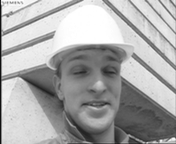

The predicted frame (Luma component):

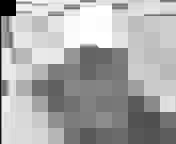

In [21]:
display(Markdown("The source frame (Luma component):"))
display(source_frame)
display(Markdown("The predicted frame (Luma component):"))
display(Image.fromarray(predicted_buffer, mode="L"))